# SmolVLM VIz 

## Step 1: Getting the Model Outputs

In [ ]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load images
image = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")

# Initialize processor and model
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-256M-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-256M-Instruct",
    torch_dtype=torch.float16,
).to(DEVICE)

# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Can you describe this image?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="pt")
inputs = inputs.to(DEVICE)

In [2]:
all_self_atts = []

generated_ids = inputs["input_ids"]
num_gen_steps = 250
for step in range(num_gen_steps):
    out = model(
        input_ids=generated_ids,
        pixel_values=inputs["pixel_values"],
        output_attentions=True,
        output_hidden_states=True,
        return_dict=True,
    )
    # out.attentions is a tuple of length num_layers of (B, H, T, T)
    # all_self_atts.append(out.attentions)
    if step == num_gen_steps-1:
        all_self_atts.append(out.attentions)
    
    # greedy next token
    next_tok = out.logits[:, -1].argmax(dim=-1, keepdim=True)
    generated_ids = torch.cat([generated_ids, next_tok], dim=-1)


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [3]:
decoded_tokens = [processor.tokenizer.decode([tok_id], clean_up_tokenization_spaces=False) for tok_id in generated_ids[0]]

# Extract Attention and Output and Plot

In [4]:
# Print the Joined Reponse

print(''.join(decoded_tokens[876:]).strip())

The image depicts a large, historic statue of Liberty situated on a small island in a body of water. The statue is a green, cylindrical structure with a human figure at the top, which is the actual statue of Liberty. The statue is mounted on a pedestal that is supported by a cylindrical tower. The pedestal is rectangular and appears to be made of stone or a similar material. The statue is surrounded by a large, flat, rectangular area that is likely a base for the statue.

In the background, there is a cityscape with a variety of buildings, including skyscrapers and high-rise buildings. The sky is clear with a gradient of colors, transitioning from a pale blue at the top to a deeper blue at the bottom. The buildings are mostly modern, with a mix of glass and concrete. The buildings are densely packed, with many skyscrapers and high-rise buildings visible.

There are trees and greenery visible on the left side of the image, indicating that the statue is located near a park or a park area

In [13]:
pattern = ['Ass', 'istant', ':']

# Scan through tokens for the pattern
for i in range(len(decoded_tokens) - len(pattern) + 1):
    if decoded_tokens[i:i+len(pattern)] == pattern:
        print(f"Match starts at index {i}")  # Output: 3
        break
        
answer = decoded_tokens[i:]

Match starts at index 873


In [26]:
num_layers = 30
num_heads = 9

layer_idx = 27
head_idx = 0

attention_matrix = all_self_atts[0][layer_idx][0, :, :, :].detach().cpu()

In [65]:
# This is where we find the index of the word we are interested 
# in visualizing the map for. 

word = ' statue'
statue_index = decoded_tokens.index(word)
print(f"'{word}' index: {statue_index}")

statue_attn = attention_matrix[:, statue_index, :].detach().cpu()

' city' index: 984


In [78]:
patch_indices = {}

for i, word in enumerate(decoded_tokens):
    if 'row' in word or 'global' in word:
        patch_indices[word] = [i+1+j for j in range(64)]

patch_indices.keys()

dict_keys(['<row_1_col_1>', '<row_1_col_2>', '<row_1_col_3>', '<row_1_col_4>', '<row_2_col_1>', '<row_2_col_2>', '<row_2_col_3>', '<row_2_col_4>', '<row_3_col_1>', '<row_3_col_2>', '<row_3_col_3>', '<row_3_col_4>', '<global-img>'])

In [70]:
def reshape_patch(patch):
    expanded_patch = np.zeros((512, 512))
    # square_patch = patch.reshape(8, 8)
    square_patch = patch.to(dtype=torch.float16).reshape(8, 8).cpu().numpy()
    # Expecting a 1x64 array and we want to transform to 512x512
    for i in range(8):
        for j in range(8):
            expanded_section = np.ones((64, 64)) * square_patch[i][j]
            expanded_patch[i*64:i*64 + 64, j*64:j*64+64] = expanded_section
            
    return expanded_patch

In [71]:
statue_attn.shape

torch.Size([9, 1075])

# Visualizing the attention map

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def gen_attn_map(statue_attn):

    num_rows = 3
    num_cols = 4
    
    final_heatmap = np.zeros((512 * num_rows, 512 * num_cols))
    
    for i in range(num_rows):
        for j in range(num_cols):
            indices = patch_indices[f"<row_{i+1}_col_{j+1}>"]
            attn_path = statue_attn[indices]
            p = reshape_patch(attn_path)  # Make sure this returns a (512, 512) np.array
            final_heatmap[i*512:i*512 + 512, j*512: j*512 + 512] = p

    return final_heatmap


In [99]:
import cv2
def reshape_global_patch(patch):
    expanded_patch = np.zeros((512, 512))
    # square_patch = patch.reshape(8, 8)
    square_patch = patch.to(dtype=torch.float16).reshape(8, 8).cpu().numpy()
    # # Expecting a 1x64 array and we want to transform to 512x512
    for i in range(8):
        for j in range(8):
            expanded_section = np.ones((64, 64)) * square_patch[i][j]
            expanded_patch[i*64:i*64 + 64, j*64:j*64+64] = expanded_section
    print(square_patch.shape)
    expanded_global_path = cv2.resize(expanded_patch, (2048, 1536),  interpolation=cv2.INTER_LINEAR)
    
            
    return expanded_global_path

(8, 8)


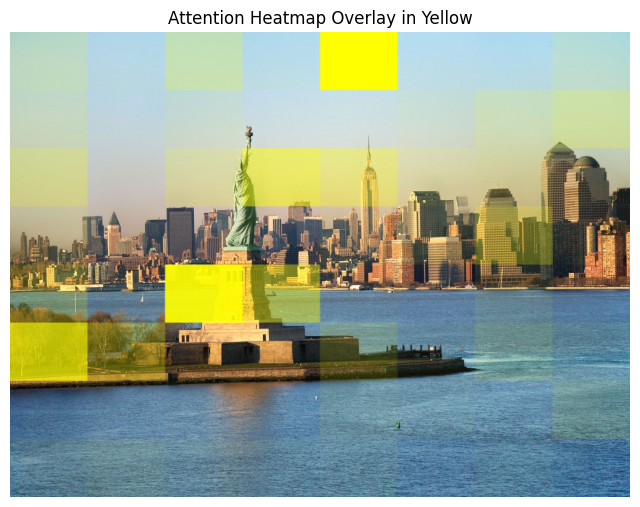

In [100]:
indices = patch_indices["<global-img>"]
attn_path = statue_attn[0][indices]
global_heatmap = reshape_global_patch(attn_path)  # Make sure this returns a (512, 512) np.array
plot_overlay(global_heatmap, image)


# Overlaying onto the image

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

def plot_overlay(final_heatmap, image):

    # Normalize heatmap to [0, 1] for alpha blending
    normalized_heatmap = (final_heatmap - final_heatmap.min()) / (final_heatmap.max() - final_heatmap.min())
    
    # Resize image to match heatmap
    resized_image = image.resize((2048, 1536), resample=Image.BILINEAR)
    
    # Create a custom colormap: from transparent to yellow
    yellow_cmap = LinearSegmentedColormap.from_list(
        "yellow_alpha", [(1, 1, 0, 0), (1, 1, 0, 1)], N=256  # RGBA: from transparent to full yellow
    )
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(resized_image)
    plt.imshow(normalized_heatmap, cmap=yellow_cmap, alpha=normalized_heatmap)
    plt.axis("off")
    plt.title("Attention Heatmap Overlay in Yellow")
    plt.show()


tensor(0.5303, dtype=torch.float16) tensor(0)


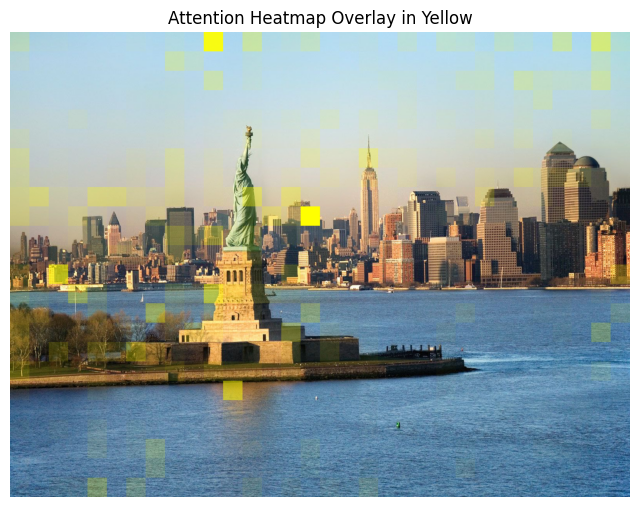

tensor(0.4084, dtype=torch.float16) tensor(983)


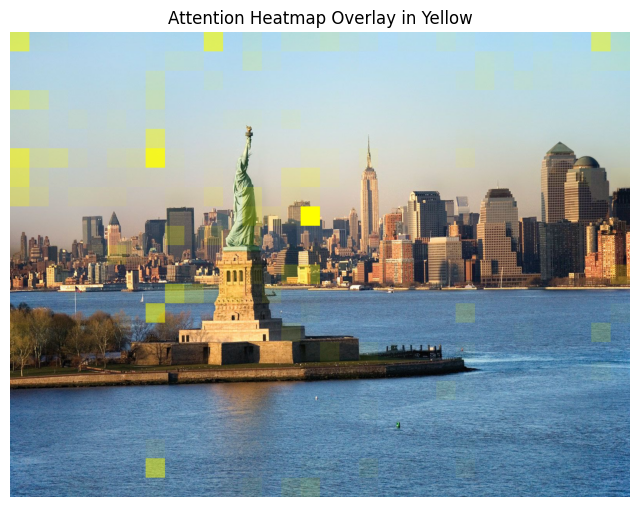

tensor(0.5752, dtype=torch.float16) tensor(0)


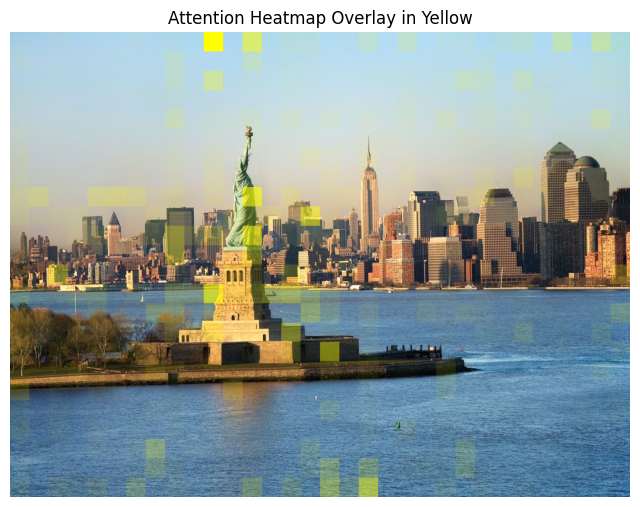

tensor(0.5010, dtype=torch.float16) tensor(984)


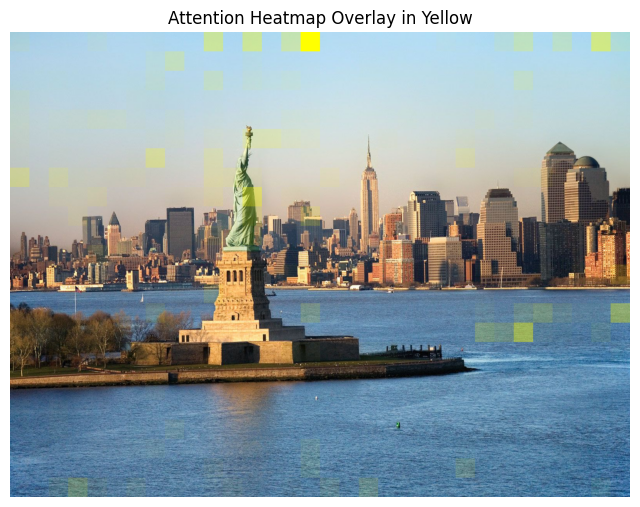

tensor(0.8818, dtype=torch.float16) tensor(0)


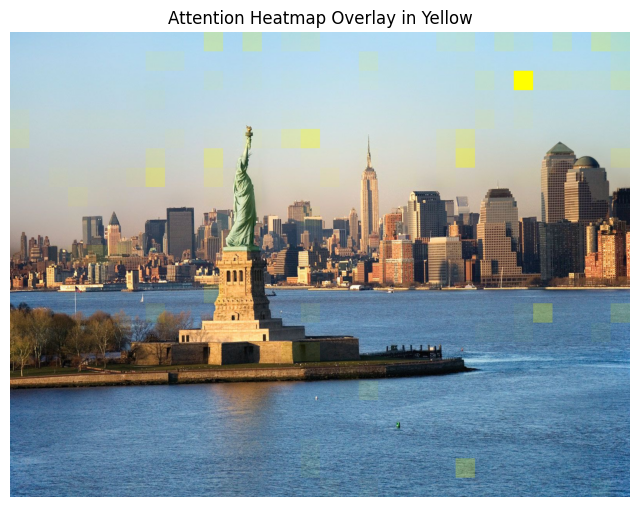

tensor(0.3508, dtype=torch.float16) tensor(0)


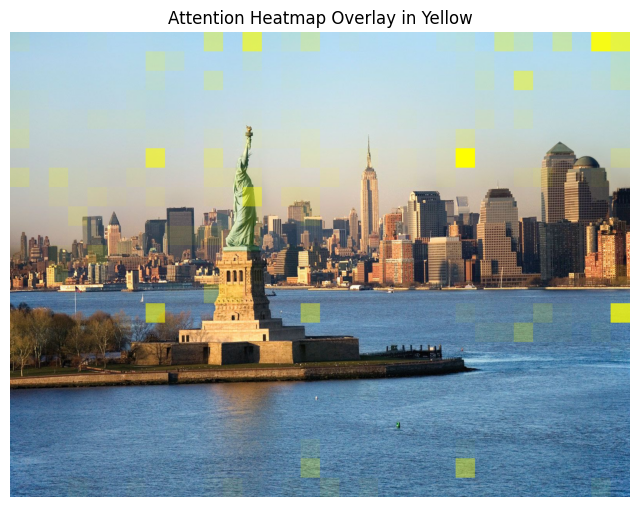

tensor(0.6104, dtype=torch.float16) tensor(983)


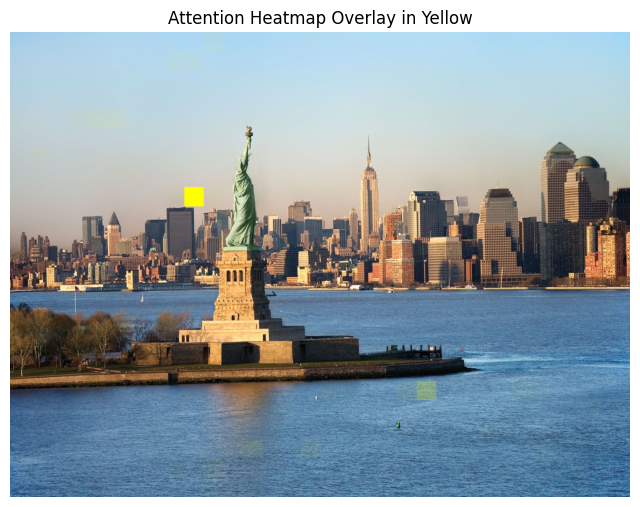

tensor(0.3464, dtype=torch.float16) tensor(0)


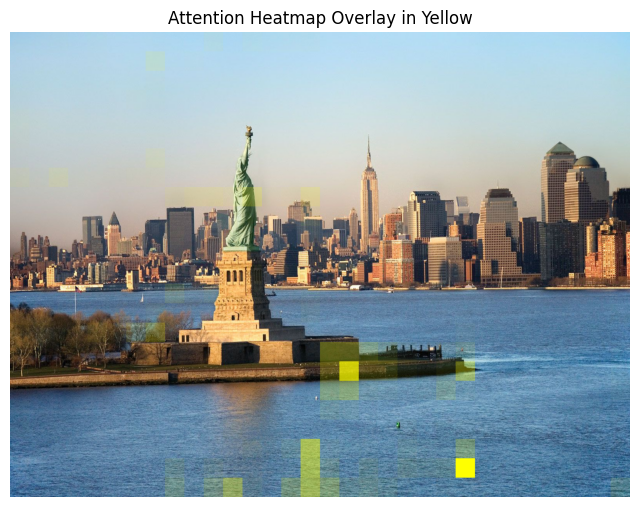

tensor(0.6538, dtype=torch.float16) tensor(0)


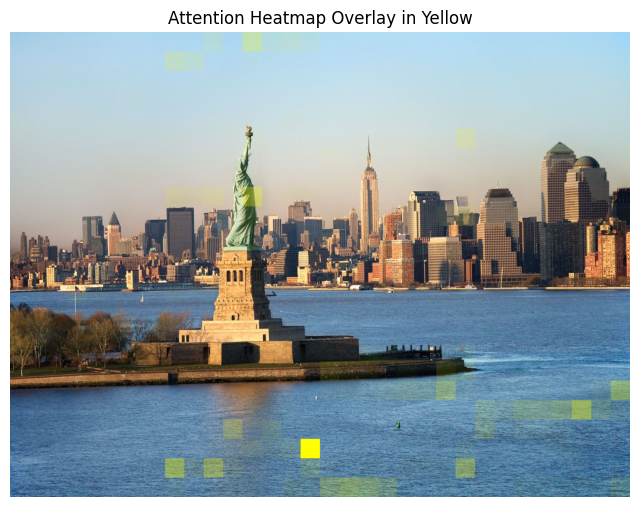

In [76]:
# Plot the attention map for each head

for i in range(9):
    h = plot_attn_map(statue_attn[i])
    plot_overlay(h, image)